In [99]:
%matplotlib notebook
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import widgets
import sncosmo
import marshaltools
from ast import literal_eval
import logging
from astropy.time import Time
import requests

DEBUG:matplotlib.backends:backend nbAgg version unknown


In [58]:
username = 'jnordin'
date = '2018-09-23'
maxz = 0.1
minpeakmag = 19.5   # A candidate need to have at least one detection brigther than this
mindet = 5          # A candidate need to have at least this many detections
maxage = 30         # If a detection has an age older than this, skip (stars,age). 
                    # Q: How can histories be older than 30days?
filepath = '~/Downloads/'
logging.basicConfig(filename=filepath+'ztfcosmo_%s_%s.log'%(date,username),level=logging.DEBUG)


In [3]:
df_sum = pd.read_csv(filepath+"Summary_%s.csv"%(date))
df_phot = pd.read_csv(filepath+"Photometry_%s.csv"%(date))

In [48]:
logging.info("There were %s candidates reported %s"%(df_sum.shape[0],date))

INFO:root:There were 183 candidates reported 2018-09-23


In [49]:
# Find already classified SNe
i_untyped = (df_sum["T2-classification"]== "None") | (df_sum["T2-classification"].isnull())
df_classified = df_sum[ ~i_untyped]
df_tmp = df_sum[ i_untyped]
logging.info("Out of these %s already have Marshal type and will be skipped."%len(df_classified))


INFO:root:Out of these 47 already have Marshal type and will be skipped.


In [50]:
# Are there any remaining candidates with  
i_highz = ( (df_tmp['T2-NEDz_z']>maxz) | (df_tmp['T2-milliquas_redshift']>maxz)  | (df_tmp['T2-SDSS_spec_z']>maxz) ) 
df_classified = df_tmp[ i_highz]
df_tmp2 = df_tmp[~i_highz]
logging.info("%s have a catalog z larger than %s  and will be skipped."%(np.sum(i_highz),maxz))


INFO:root:3 have a catalog z larger than 0.1  and will be skipped.


In [51]:
# Which are already saved in the marshal?
i_unsaved = (df_tmp2["T2-programs"]== "[]") | (df_tmp2["T2-programs"].isnull())
df_saved = df_tmp2[~i_unsaved]
df_candidates = df_tmp2[i_unsaved]
logging.info("Detected %s already saved candidates and %s new"%(len(df_saved),len(df_candidates)))

INFO:root:Detected 25 already saved candidates and 108 new


In [29]:
for sne in df_saved.iterrows():
    print( sne[1]["ztf_name"] )
    marshalprog =  literal_eval(sne[1]["T2-programs"])[0] 
    if marshalprog=='AMPEL' : marshalprog = marshalprog + ' Test'
    
    pl = marshaltools.ProgramList(marshalprog)
    lc = pl.get_lightcurve(sne[1]["ztf_name"])
    print(lc.table_sncosmo)
    
    # Get photometry
    phot = df_phot[ df_phot["ztf_name"]==sne[1]["ztf_name"] ]
    filters = phot["fid"]
    jd = phot["jd"]
    magpsf = phot['magpsf']
    
    break

DEBUG:marshaltools.ProgramList:listing accessible programs
DEBUG:marshaltools.ProgramList:Starting list_programs.cgi post. Attempt # 0


ZTF18abucflq


DEBUG:marshaltools.ProgramList:request URL: http://skipper.caltech.edu:8080/cgi-bin/growth/list_programs.cgi?None
DEBUG:marshaltools.ProgramList:Successful growth connection.
INFO:marshaltools.ProgramList:Initialized ProgramList for program AMPEL Test (ID 4)
DEBUG:marshaltools.ProgramList:Starting list_program_sources.cgi post. Attempt # 0
DEBUG:marshaltools.ProgramList:request URL: http://skipper.caltech.edu:8080/cgi-bin/growth/list_program_sources.cgi?programidx=4&getredshift=1&getclassification=1
DEBUG:marshaltools.ProgramList:Successful growth connection.
INFO:marshaltools.ProgramList:Loaded 171 saved sources for program AMPEL Test.
DEBUG:marshaltools.gci_utils:Starting print_lc.cgi post. Attempt # 0
DEBUG:marshaltools.gci_utils:request URL: http://skipper.caltech.edu:8080/cgi-bin/growth/print_lc.cgi?name=ZTF18abucflq
DEBUG:marshaltools.gci_utils:Successful growth connection.


       mjd         band        flux             fluxerr        zp  zpsys
------------------ ---- ------------------ ------------------ ---- -----
 58348.34840000002 p48g                0.0  8.892625349382186 25.0    ab
 58351.21560000023 p48r                0.0 12.503453855513698 25.0    ab
58354.264800000004 p48r                0.0 15.453611701914037 25.0    ab
        58354.3591 p48r                0.0 20.371827761082336 25.0    ab
58357.200999999885 p48r                0.0 21.929563922863725 25.0    ab
58357.304599999916 p48r                0.0 22.337264955611246 25.0    ab
 58360.27600000007 p48r                0.0 13.459533125686363 25.0    ab
58363.196899999864 p48g                0.0   9.75056980206772 25.0    ab
58363.245600000024 p48r                0.0  12.85375434634039 25.0    ab
58366.184900000226 p48r                0.0 10.210099999508124 25.0    ab
58366.243300000206 p48g                0.0  7.674144909845585 25.0    ab
 58369.19609999983 p48r  85.50667128846823 15.75091

In [62]:
# Examine new candidates, build a list of the onces fulfilling basic criteria
sncandidates = []
for sne in df_candidates.iterrows():
    print( sne[1]["ztf_name"] )
    phot = df_phot[ df_phot["ztf_name"]==sne[1]["ztf_name"] ]
    filters = phot["fid"]
    jd = phot["jd"]
    magpsf = phot['magpsf']
    if np.min(magpsf)> minpeakmag:
        msg = "%s: Skipping %s, never reached limit %s"%(date,sne[1]["ztf_name"],minpeakmag)
        logging.info(msg)
        print(msg)
        continue
    if len(magpsf)< mindet:
        msg = "%s: Skipping %s, less than %s detections"%(date,sne[1]["ztf_name"],mindet)
        logging.info(msg)
        print(msg)
        continue

    age = np.max(jd)-np.min(jd)
    if age>maxage:
        msg = "%s: Skipping %s, age %s longer than limit %s"%(date,sne[1]["ztf_name"],age,maxage)
        logging.info(msg)
        print(msg)
        continue
        
    sncandidates.append(sne[1]["ztf_name"])
    continue
        
    

print("Left with %s candidates to scan"%(len(sncandidates)))

INFO:root:2018-09-23: Skipping ZTF18abwusgl, less than 5 detections
INFO:root:2018-09-23: Skipping ZTF18abslxpd, age 39.03981479955837 longer than limit 30
INFO:root:2018-09-23: Skipping ZTF18abyenql, less than 5 detections
INFO:root:2018-09-23: Skipping ZTF18aaupjtd, age 46.06000000005588 longer than limit 30
INFO:root:2018-09-23: Skipping ZTF18aayaphx, age 46.996886500157416 longer than limit 30
INFO:root:2018-09-23: Skipping ZTF18aamhnti, age 49.95512729976326 longer than limit 30
INFO:root:2018-09-23: Skipping ZTF18abnvotk, age 35.85531250014901 longer than limit 30
INFO:root:2018-09-23: Skipping ZTF18abhpdpk, never reached limit 19.5
INFO:root:2018-09-23: Skipping ZTF18abehrdw, age 45.064872700255364 longer than limit 30
INFO:root:2018-09-23: Skipping ZTF18absmsbm, never reached limit 19.5
INFO:root:2018-09-23: Skipping ZTF18aaodyze, age 42.88599539967254 longer than limit 30
INFO:root:2018-09-23: Skipping ZTF18abtcdfv, never reached limit 19.5
INFO:root:2018-09-23: Skipping ZTF18

ZTF18abwusgl
2018-09-23: Skipping ZTF18abwusgl, less than 5 detections
ZTF18abvnwzz
ZTF18abslxpd
2018-09-23: Skipping ZTF18abslxpd, age 39.03981479955837 longer than limit 30
ZTF18abyenql
2018-09-23: Skipping ZTF18abyenql, less than 5 detections
ZTF18aaupjtd
2018-09-23: Skipping ZTF18aaupjtd, age 46.06000000005588 longer than limit 30
ZTF18abecggb
ZTF18ablwolq
ZTF18aayaphx
2018-09-23: Skipping ZTF18aayaphx, age 46.996886500157416 longer than limit 30
ZTF18aamhnti
2018-09-23: Skipping ZTF18aamhnti, age 49.95512729976326 longer than limit 30
ZTF18abnvotk
2018-09-23: Skipping ZTF18abnvotk, age 35.85531250014901 longer than limit 30
ZTF18abqboud
ZTF18abvhasp
ZTF18abhpdpk
2018-09-23: Skipping ZTF18abhpdpk, never reached limit 19.5
ZTF18abehrdw
2018-09-23: Skipping ZTF18abehrdw, age 45.064872700255364 longer than limit 30
ZTF18absmsbm
2018-09-23: Skipping ZTF18absmsbm, never reached limit 19.5
ZTF18aaodyze
2018-09-23: Skipping ZTF18aaodyze, age 42.88599539967254 longer than limit 30
ZTF18abh

INFO:root:2018-09-23: Skipping ZTF18abxishs, less than 5 detections
INFO:root:2018-09-23: Skipping ZTF18aazydub, never reached limit 19.5
INFO:root:2018-09-23: Skipping ZTF18abmsmnc, age 40.04186340002343 longer than limit 30
INFO:root:2018-09-23: Skipping ZTF18abxfcql, less than 5 detections
INFO:root:2018-09-23: Skipping ZTF18abytyjb, never reached limit 19.5
INFO:root:2018-09-23: Skipping ZTF18abtzisn, never reached limit 19.5
INFO:root:2018-09-23: Skipping ZTF18abnvnqb, age 35.85486110020429 longer than limit 30
INFO:root:2018-09-23: Skipping ZTF18abmsngt, age 40.0423494996503 longer than limit 30
INFO:root:2018-09-23: Skipping ZTF17aabihdn, age 41.002847200259566 longer than limit 30
INFO:root:2018-09-23: Skipping ZTF18aampiwv, age 46.89600689988583 longer than limit 30
INFO:root:2018-09-23: Skipping ZTF18aboncwu, never reached limit 19.5
INFO:root:2018-09-23: Skipping ZTF18aburkuo, never reached limit 19.5
INFO:root:2018-09-23: Skipping ZTF18abnvirx, age 36.0025809998624 longer t

ZTF18abxishs
2018-09-23: Skipping ZTF18abxishs, less than 5 detections
ZTF18abwcgyo
ZTF18abslxhz
ZTF18aazydub
2018-09-23: Skipping ZTF18aazydub, never reached limit 19.5
ZTF18abmsmnc
2018-09-23: Skipping ZTF18abmsmnc, age 40.04186340002343 longer than limit 30
ZTF18abxfcql
2018-09-23: Skipping ZTF18abxfcql, less than 5 detections
ZTF18abytyjb
2018-09-23: Skipping ZTF18abytyjb, never reached limit 19.5
ZTF18abtzisn
2018-09-23: Skipping ZTF18abtzisn, never reached limit 19.5
ZTF18abnvnqb
2018-09-23: Skipping ZTF18abnvnqb, age 35.85486110020429 longer than limit 30
ZTF18abmsngt
2018-09-23: Skipping ZTF18abmsngt, age 40.0423494996503 longer than limit 30
ZTF17aabihdn
2018-09-23: Skipping ZTF17aabihdn, age 41.002847200259566 longer than limit 30
ZTF18aampiwv
2018-09-23: Skipping ZTF18aampiwv, age 46.89600689988583 longer than limit 30
ZTF18abrwrch
ZTF18abwdcdv
ZTF18aboncwu
2018-09-23: Skipping ZTF18aboncwu, never reached limit 19.5
ZTF18aburkuo
2018-09-23: Skipping ZTF18aburkuo, never reach

INFO:root:2018-09-23: Skipping ZTF18abyteqb, less than 5 detections
INFO:root:2018-09-23: Skipping ZTF17aacdtdm, less than 5 detections
INFO:root:2018-09-23: Skipping ZTF18abtobub, never reached limit 19.5
INFO:root:2018-09-23: Skipping ZTF18abdkkwa, age 49.9788772999309 longer than limit 30
INFO:root:2018-09-23: Skipping ZTF18abmsmtt, age 40.04281250014901 longer than limit 30
INFO:root:2018-09-23: Skipping ZTF18aaqzomm, age 36.91467590024695 longer than limit 30
INFO:root:2018-09-23: Skipping ZTF18abyckee, less than 5 detections
INFO:root:2018-09-23: Skipping ZTF18abxazsz, never reached limit 19.5
INFO:root:2018-09-23: Skipping ZTF18abyckme, less than 5 detections
INFO:root:2018-09-23: Skipping ZTF18absnmdd, never reached limit 19.5
INFO:root:2018-09-23: Skipping ZTF18abytfxc, never reached limit 19.5
INFO:root:2018-09-23: Skipping ZTF18abfkzjd, age 45.82319450005889 longer than limit 30
INFO:root:2018-09-23: Skipping ZTF18aaxudip, age 48.019444399513304 longer than limit 30
INFO:roo

2018-09-23: Skipping ZTF18abyteqb, less than 5 detections
ZTF17aacdtdm
2018-09-23: Skipping ZTF17aacdtdm, less than 5 detections
ZTF18aakgsmi
ZTF18abtobub
2018-09-23: Skipping ZTF18abtobub, never reached limit 19.5
ZTF18abxikgn
ZTF18abdkkwa
2018-09-23: Skipping ZTF18abdkkwa, age 49.9788772999309 longer than limit 30
ZTF18abydspi
ZTF18aauedot
ZTF18abmsmtt
2018-09-23: Skipping ZTF18abmsmtt, age 40.04281250014901 longer than limit 30
ZTF18abuxpun
ZTF18aaowwgf
ZTF18aaakpmq
ZTF18aaqzomm
2018-09-23: Skipping ZTF18aaqzomm, age 36.91467590024695 longer than limit 30
ZTF18abyckee
2018-09-23: Skipping ZTF18abyckee, less than 5 detections
ZTF18abwfmot
ZTF18abxazsz
2018-09-23: Skipping ZTF18abxazsz, never reached limit 19.5
ZTF18abyckme
2018-09-23: Skipping ZTF18abyckme, less than 5 detections
ZTF18absnmdd
2018-09-23: Skipping ZTF18absnmdd, never reached limit 19.5
ZTF18abytfxc
2018-09-23: Skipping ZTF18abytfxc, never reached limit 19.5
ZTF18abxqzih
ZTF18abfkzjd
2018-09-23: Skipping ZTF18abfkzjd, 

INFO:root:2018-09-23: Skipping ZTF18aanvpol, age 49.93771990016103 longer than limit 30
INFO:root:2018-09-23: Skipping ZTF18abitwua, age 49.9795834007673 longer than limit 30
INFO:root:2018-09-23: Skipping ZTF18abwtops, never reached limit 19.5
INFO:root:2018-09-23: Skipping ZTF18abpfbri, never reached limit 19.5
INFO:root:2018-09-23: Skipping ZTF18abytwah, never reached limit 19.5
INFO:root:2018-09-23: Skipping ZTF18abcleke, age 35.8923842003569 longer than limit 30
INFO:root:2018-09-23: Skipping ZTF18abgqvwv, age 50.95193289965391 longer than limit 30
INFO:root:2018-09-23: Skipping ZTF18abuakku, never reached limit 19.5



ZTF18aanvpol
2018-09-23: Skipping ZTF18aanvpol, age 49.93771990016103 longer than limit 30
ZTF18abvxbfh
ZTF18abitwua
2018-09-23: Skipping ZTF18abitwua, age 49.9795834007673 longer than limit 30
ZTF18abukmty
ZTF18abbmenz
ZTF18abwtops
2018-09-23: Skipping ZTF18abwtops, never reached limit 19.5
ZTF18abpfbri
2018-09-23: Skipping ZTF18abpfbri, never reached limit 19.5
ZTF18abwklar
ZTF18abytwah
2018-09-23: Skipping ZTF18abytwah, never reached limit 19.5
ZTF18abcleke
2018-09-23: Skipping ZTF18abcleke, age 35.8923842003569 longer than limit 30
ZTF18abgqvwv
2018-09-23: Skipping ZTF18abgqvwv, age 50.95193289965391 longer than limit 30
ZTF18abuakku
2018-09-23: Skipping ZTF18abuakku, never reached limit 19.5
ZTF18abwdhgw
Left with 42 candidates to scan


<IPython.core.display.Javascript object>


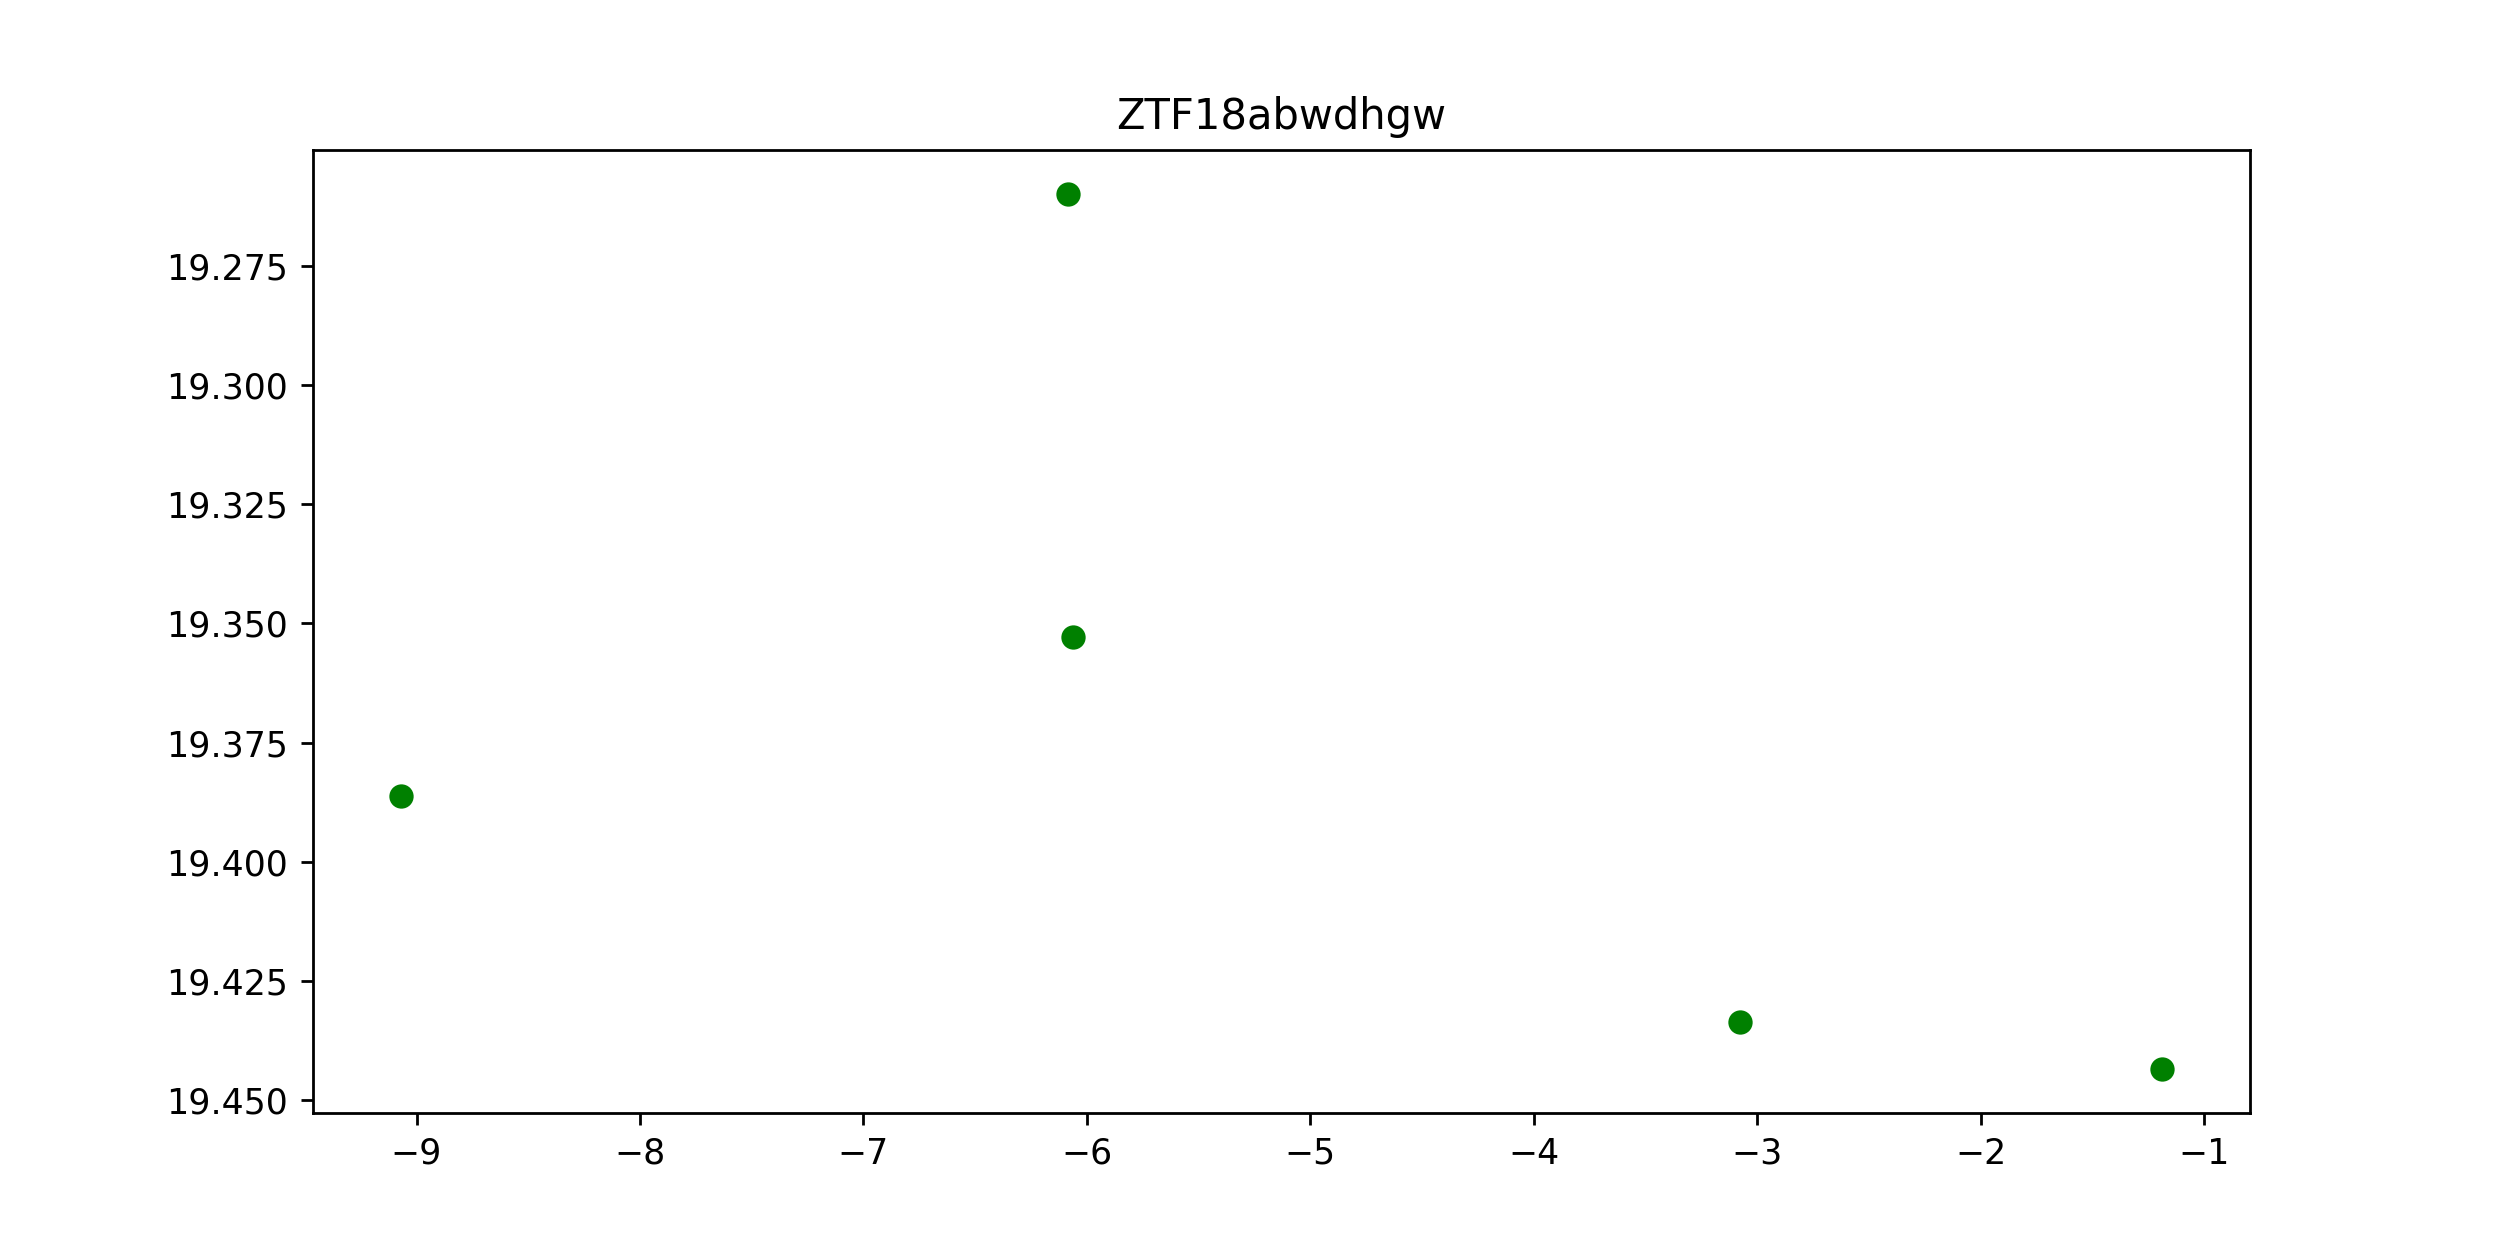

In [61]:
# Evaluate candidate
sn = sncandidates.pop()
phot = df_phot[ df_phot["ztf_name"]==sn ]
filters = phot["fid"]
jd = phot["jd"]
magpsf = phot['magpsf']
plt.figure(figsize=(10,5))
plt.title(sne[1]["ztf_name"])
plt.plot(jd[filters==1]-Time.now().jd,magpsf[filters==1],'go')
plt.plot(jd[filters==2]-Time.now().jd,magpsf[filters==2],'ro')
plt.gca().invert_yaxis()
plt.show()
    

In [67]:
# Look at ingesting these
starttime = Time.now()
print(starttime.utc)

In [81]:
# Lets be panicky and check again if any of these candidates has been added to the programs we know
programstocheck = []
sne_postsaved = []
for progstring in df_saved["T2-programs"]:
    marshalprogs =  literal_eval(progstring)
    for prog in marshalprogs:
        if prog=='AMPEL' : prog = prog + ' Test'
        if prog=='RCF' : prog = 'Redshift Completeness Factor'
        if not prog in programstocheck : programstocheck.append(prog)
for prog in programstocheck:
    pl = marshaltools.ProgramList(prog)
    pl.get_saved_sources()
    for snname in sncandidates:
        if snname in pl.sources.keys():
            msg = "Marshal save conflict: %s listed as candidate but saved in program %s"%(snname,prog)
            logging.info(msg)
            if not snname in sne_postsaved : sne_postsaved.append(snname)
            


DEBUG:marshaltools.ProgramList:listing accessible programs
DEBUG:marshaltools.ProgramList:Starting list_programs.cgi post. Attempt # 0
DEBUG:marshaltools.ProgramList:request URL: http://skipper.caltech.edu:8080/cgi-bin/growth/list_programs.cgi?None
DEBUG:marshaltools.ProgramList:Successful growth connection.
INFO:marshaltools.ProgramList:Initialized ProgramList for program AMPEL Test (ID 4)
DEBUG:marshaltools.ProgramList:Starting list_program_sources.cgi post. Attempt # 0
DEBUG:marshaltools.ProgramList:request URL: http://skipper.caltech.edu:8080/cgi-bin/growth/list_program_sources.cgi?programidx=4&getredshift=1&getclassification=1
DEBUG:marshaltools.ProgramList:Successful growth connection.
INFO:marshaltools.ProgramList:Loaded 171 saved sources for program AMPEL Test.
DEBUG:marshaltools.ProgramList:Starting list_program_sources.cgi post. Attempt # 0
DEBUG:marshaltools.ProgramList:request URL: http://skipper.caltech.edu:8080/cgi-bin/growth/list_program_sources.cgi?programidx=4&getredsh

In [82]:
# Now, lets look at whether any of the remaining candidates are still candidates 
# Get the 
pl = marshaltools.ProgramList('AMPEL Test')
candidates = pl.get_candidates()

DEBUG:marshaltools.ProgramList:listing accessible programs
DEBUG:marshaltools.ProgramList:Starting list_programs.cgi post. Attempt # 0
DEBUG:marshaltools.ProgramList:request URL: http://skipper.caltech.edu:8080/cgi-bin/growth/list_programs.cgi?None
DEBUG:marshaltools.ProgramList:Successful growth connection.
INFO:marshaltools.ProgramList:Initialized ProgramList for program AMPEL Test (ID 4)
DEBUG:marshaltools.ProgramList:Starting list_program_sources.cgi post. Attempt # 0
DEBUG:marshaltools.ProgramList:request URL: http://skipper.caltech.edu:8080/cgi-bin/growth/list_program_sources.cgi?programidx=4&getredshift=1&getclassification=1
DEBUG:marshaltools.ProgramList:Successful growth connection.
INFO:marshaltools.ProgramList:Loaded 171 saved sources for program AMPEL Test.
INFO:marshaltools.ProgramList:Getting scanning page transient for program AMPEL Test between 2018-03-01 00:00:00 and 2018-09-24 13:32:51 using dt: 120.00 h
INFO:marshaltools.ProgramList:Downloading candidates. Iteration 

DEBUG:marshaltools.ProgramList:querying scanning page of program AMPEL Test (scienceprogram 42) for ingested times between 2018-05-25 00:00:00 and 2018-05-30 00:00:00
DEBUG:marshaltools.ProgramList:Successful growth connection.
DEBUG:marshaltools.ProgramList:Starting list_candidates.cgi post. Attempt # 0
DEBUG:marshaltools.ProgramList:retrieved 0 sources
DEBUG:marshaltools.ProgramList:querying scanning page of program AMPEL Test (scienceprogram 42) for ingested times between 2018-05-30 00:00:00 and 2018-06-04 00:00:00
DEBUG:marshaltools.ProgramList:Query from 2018-03-01 00:00:00.000 to 2018-03-06 00:00:00.000 returned 0 candidates. Total: 0
DEBUG:marshaltools.ProgramList:Starting list_candidates.cgi post. Attempt # 0
DEBUG:marshaltools.ProgramList:request URL: http://skipper.caltech.edu:8080/cgi-bin/growth/list_candidates.cgi?scienceprogram=42&startdate=2018-03-21+00%3A00%3A00&enddate=2018-03-26+00%3A00%3A00&showSaved=all
DEBUG:marshaltools.ProgramList:request URL: http://skipper.calte

DEBUG:marshaltools.ProgramList:Query from 2018-05-30 00:00:00.000 to 2018-06-04 00:00:00.000 returned 0 candidates. Total: 0
DEBUG:marshaltools.ProgramList:querying scanning page of program AMPEL Test (scienceprogram 42) for ingested times between 2018-07-24 00:00:00 and 2018-07-29 00:00:00
DEBUG:marshaltools.ProgramList:retrieved 1 sources
DEBUG:marshaltools.ProgramList:Starting list_candidates.cgi post. Attempt # 0
DEBUG:marshaltools.ProgramList:querying scanning page of program AMPEL Test (scienceprogram 42) for ingested times between 2018-07-29 00:00:00 and 2018-08-03 00:00:00
DEBUG:marshaltools.ProgramList:Query from 2018-06-14 00:00:00.000 to 2018-06-19 00:00:00.000 returned 1 candidates. Total: 1
DEBUG:marshaltools.ProgramList:Starting list_candidates.cgi post. Attempt # 0
DEBUG:marshaltools.ProgramList:request URL: http://skipper.caltech.edu:8080/cgi-bin/growth/list_candidates.cgi?scienceprogram=42&startdate=2018-06-04+00%3A00%3A00&enddate=2018-06-09+00%3A00%3A00&showSaved=all


DEBUG:marshaltools.ProgramList:Starting list_candidates.cgi post. Attempt # 0
DEBUG:marshaltools.ProgramList:request URL: http://skipper.caltech.edu:8080/cgi-bin/growth/list_candidates.cgi?scienceprogram=42&startdate=2018-07-24+00%3A00%3A00&enddate=2018-07-29+00%3A00%3A00&showSaved=all
DEBUG:marshaltools.ProgramList:Successful growth connection.
DEBUG:marshaltools.ProgramList:retrieved 74 sources
DEBUG:marshaltools.ProgramList:Query from 2018-07-24 00:00:00.000 to 2018-07-29 00:00:00.000 returned 74 candidates. Total: 302
DEBUG:marshaltools.ProgramList:request URL: http://skipper.caltech.edu:8080/cgi-bin/growth/list_candidates.cgi?scienceprogram=42&startdate=2018-08-23+00%3A00%3A00&enddate=2018-08-28+00%3A00%3A00&showSaved=all
DEBUG:marshaltools.ProgramList:Successful growth connection.
DEBUG:marshaltools.ProgramList:retrieved 186 sources
DEBUG:marshaltools.ProgramList:Query from 2018-08-23 00:00:00.000 to 2018-08-28 00:00:00.000 returned 186 candidates. Total: 488
DEBUG:marshaltools.P

In [85]:
oldcandidates = []
pl = marshaltools.ProgramList('AMPEL Test')
for snname in sncandidates:
    if snname in sne_postsaved : continue # It is saved, no need to worry
    if snname in pl.candidates.keys():
        msg = "Marshal candidate conflict: %s was already a candidate in AMPEL test. Trouble?"%(snname)
        logging.info(msg)
        oldcandidates.append(snname)


INFO:root:Marshal candidate conflict: ZTF18ablwolq was already a candidate. Trouble?listed as candidate but saved in program Redshift Completeness Factor
INFO:root:Marshal candidate conflict: ZTF18abqboud was already a candidate. Trouble?listed as candidate but saved in program Redshift Completeness Factor
INFO:root:Marshal candidate conflict: ZTF18abvhasp was already a candidate. Trouble?listed as candidate but saved in program Redshift Completeness Factor
INFO:root:Marshal candidate conflict: ZTF18abhfurc was already a candidate. Trouble?listed as candidate but saved in program Redshift Completeness Factor
INFO:root:Marshal candidate conflict: ZTF18abtrktm was already a candidate. Trouble?listed as candidate but saved in program Redshift Completeness Factor
INFO:root:Marshal candidate conflict: ZTF18abtkzfi was already a candidate. Trouble?listed as candidate but saved in program Redshift Completeness Factor
INFO:root:Marshal candidate conflict: ZTF18absmogv was already a candidate. 

In [86]:
# To summarize we now have four different lists of untyped transients:
# df_saved (dataframe) contains cand ampel has seen were saved
# sncandidates (list) contains ampel candidates. It has two subsets:
#   sne_postsaved (list) contains sne that were saved after ampel matching
#   oldcandidates (list) are sne that are candidates in AMPEL test
# These should be treated separately.

['ZTF18ablwolq', 'ZTF18abqboud', 'ZTF18abvhasp', 'ZTF18abhfurc', 'ZTF18abtrktm', 'ZTF18abtkzfi', 'ZTF18absmogv', 'ZTF17aaaadqv', 'ZTF18absnsqx', 'ZTF18absloer', 'ZTF18abwcgyo', 'ZTF18abvxdou', 'ZTF18abwntpz', 'ZTF18aakgsmi', 'ZTF18abxikgn', 'ZTF18abydspi', 'ZTF18aauedot', 'ZTF18abuxpun', 'ZTF18aaowwgf', 'ZTF18aaakpmq', 'ZTF18abwfmot', 'ZTF18abxqzih', 'ZTF18abujamb', 'ZTF18abvlkyj', 'ZTF18abvcrsv', 'ZTF18abtghbi', 'ZTF18aawurif', 'ZTF18abvxbfh', 'ZTF18abwklar', 'ZTF18abwdhgw']


In [103]:
# Lets try to ingest the sne that were previously candidates.
def ingest(avroid, ProgramList):
    """
    Ingesting some avro into a program described by a marshaltools ProgramList object
    """
    
    marshal_root = 'http://skipper.caltech.edu:8080/cgi-bin/growth/'
    ingest_url = marshal_root + 'ingest_avro_id.cgi'
    
    postdata = {'programidx':str(ProgramList.programidx),'avroid':str(avroid)}
    print(postdata)
    request = requests.post(ingest_url,data=postdata, auth=(ProgramList.user,ProgramList.passwd))
    return request

In [104]:
ingestoldcand_start = Time.now()
#pl = marshaltools.ProgramList('AMPEL Test')
for snname in oldcandidates:
    avroid = int( df_candidates['_id'][ df_candidates["ztf_name"]==snname ] )
    print("Trying to ingest %s through avroid %s"%(snname,int(avroid)))
    request = ingest(avroid,pl)
    print(request)
ingestoldcand_end = Time.now()
    

Trying to ingest ZTF18ablwolq through avroid 611392140415015010
{'programidx': '4', 'avroid': '611392140415015010'}
<Response [200]>
Trying to ingest ZTF18abqboud through avroid 625350533815015035
{'programidx': '4', 'avroid': '625350533815015035'}
<Response [200]>
Trying to ingest ZTF18abvhasp through avroid 619169752115015004
{'programidx': '4', 'avroid': '619169752115015004'}
<Response [200]>
Trying to ingest ZTF18abhfurc through avroid 618383811215010001
{'programidx': '4', 'avroid': '618383811215010001'}
<Response [200]>
Trying to ingest ZTF18abtrktm through avroid 616368703815015022
{'programidx': '4', 'avroid': '616368703815015022'}
<Response [200]>
Trying to ingest ZTF18abtkzfi through avroid 625404164015015061
{'programidx': '4', 'avroid': '625404164015015061'}
<Response [200]>
Trying to ingest ZTF18absmogv through avroid 611203053115015002
{'programidx': '4', 'avroid': '611203053115015002'}
<Response [200]>
Trying to ingest ZTF17aaaadqv through avroid 626453721115015136
{'pro

In [105]:
ingestoldcand_start

<Time object: scale='utc' format='datetime' value=2018-09-24 14:04:09.324950>

In [106]:
ingestoldcand_end

<Time object: scale='utc' format='datetime' value=2018-09-24 14:34:52.848645>